In [20]:
import numpy as np
import math
import matplotlib.pyplot as plt
import csv
import random
import scipy.optimize
import seaborn as sns
#from IPython import display, HTML
#display(HTML("<style>div.output_scroll { height: 50em; }</style>"))
%matplotlib inline
    
def runSim(T0i, endTime, out, T_F, thermalMass, scaleF, scaleH):
    time_S = [] #time_S list
    #Temperatures in Kelvin
    temp_S = [T0i] #Average block temp under heater
    #Heat transfer in Watts (J/s)
    Q_H = [] #Power from heater to block
    Q_F = [] #Power from block to finger
    Q_net = [] #Net power in/out block
    heaterPower = 50
    gradient_S = [0] #Change in temperature over time_S
    i = 0
    while True:
        if len(time_S) == 0:
            time_S.append(0.0)
        else:
            time_S.append(round(time_S[-1]+dt,6)) 
        #Heater and block
        Q_H.append(scaleH * heaterPower * out)
        Q_F.append(scaleF * (T_F - temp_S[-1]))
        Q_net.append(Q_H[-1]+Q_F[-1])
        DeltaTemp_S = Q_net[-1] * dt / thermalMass
        temp_S.append(temp_S[-1] + DeltaTemp_S)
        if len(temp_S) >= 2:
            gradient_S.append((temp_S[-1] - temp_S[-2]) / dt)
        if ((time_S[-1].is_integer() == True) and (int(time_S[-1]) % 60 == 0)):
            #print simulation time
            hours = int(time_S[-1]//(60*60))
            minutes = int(time_S[-1]/60 - hours * 60)
            if minutes < 10:
                minutes = str(0) + str(minutes)
            if hours < 10:
                hours = str(0) + str(hours)
            timeStamp = str(hours) + ':' + str(minutes)
            #print(timeStamp, end='\r')
        if time_S[-1] >= endTime:
            break
        result_S = [time_S, temp_S, gradient_S, Q_H, Q_F, Q_net]
    return result_S

def readFile(filename):
    data = []
    with open(filename) as csvfile: 
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            row=[i for i in row if i] # remove empty spaces from row
            data.append(row)
        #print(data[0])
        data.pop(0)
    return data

def fo(t, K, tau, y0=0):
    #https://github.com/alchemyst/Dynamics-and-Control/blob/master/tbcontrol/responses.py
    # First Order response with bias
    return y0 + np.sign(K)*np.maximum(0, abs(K)*(1 - np.exp(-(t - np.min(t))/tau)))

def getTimeTempE(outputList, results_E):
    for j in range(0, len(outputList)):
        resultArrs_E = np.array(results_E[j]).T
        timeList_E = resultArrs_E[0]
        tempList_E = resultArrs_E[1]
        timeList_E = list(map(float, timeList_E))
        tempList_E = list(map(float, tempList_E))
        time_E.append(np.array(timeList_E) - timeList_E[0])
        temp_E.append(np.array(tempList_E))
    return time_E, temp_E

def compare(T_F, thermalMass, scaleF, scaleH):
    percentRMS = []
    tempFitSPoints = []
    results_S = []
    for i in range(0, len(outputList)):
        #results_S = runSim(T0[i], time_E[i][-1], T_F, thermalMass, scaleF, scaleH, scaleR, T_env)
        #results_S.append(runSim(T0[i], time_E[i][-1], T_F, thermalMass, scaleF, scaleH, scaleR, T_env))
        results_S.append(runSim(T0[i], time_E[i][-1], outputList[i]/100, T_F, thermalMass, scaleF, scaleH))
        #plt.plot(results_S[i][0], results_S[i][1][:-1])
        #plt.show()
        #tempFitSPoints = fo(results_S[0], K, tau, T0)
        tempFitSPoints = fo(np.array(results_S[i][0]), T_K[i], tau[i], T0[i])
        percentRMS.append(np.sqrt(np.mean(np.square(np.array((results_S[i][1][:-1]) - np.array(tempFitSPoints))\
                                                    /(0.5*(results_S[i][1][:-1] + np.array(tempFitSPoints)))))))
    #print(percentRMS)
    totalpercentDiff = np.sum(percentRMS)
    return totalpercentDiff

def compareOneOutput(T_F, thermalMass, scaleF, scaleH):
    percentRMS = []
    outputNo = 6 #change this to the output you want to fit to
    results_S = runSim(T0[outputNo], time_E[outputNo][-1], outputList[outputNo]/100, T_F, thermalMass, scaleF, scaleH)
    tempFitSPoints = fo(np.array(results_S[0]), T_K[outputNo], tau[outputNo], T0[outputNo])
    percentRMS = np.sqrt(np.mean(np.square(np.array((results_S[1][:-1]) - np.array(tempFitSPoints))\
                                           /(0.5*(results_S[1][:-1] + np.array(tempFitSPoints))))))
    return percentRMS

def compareByOutput(T_F_Vals, thermalMass_Vals, scaleF_Vals, scaleH_Vals):
    best_params = []
    progressCounter = 0
    totalCalcs = len(outputList) * len(T_F_Vals) * len(thermalMass_Vals) * len(scaleF_Vals) * len(scaleH_Vals)
    for i in range(0, len(outputList)):
        bestPercentDiffRMS = float('inf')
        for T_F in T_F_Vals:
            for thermalMass in thermalMass_Vals:
                for scaleF in scaleF_Vals:
                    for scaleH in scaleH_Vals:
                        results_S = runSim(T0[i], time_E[i][-1], outputList[i]/100, T_F, thermalMass, scaleF, scaleH)
                        tempFitSPoints = fo(np.array(results_S[0]), T_K[i], tau[i], T0[i])
                        percentDiffRMS = np.sqrt(np.mean(np.square((np.array(results_S[1][:-1]) - np.array(tempFitSPoints))\
                                                                   /(0.5*(np.array(results_S[1][:-1]) + np.array(tempFitSPoints))))))
                        if percentDiffRMS < bestPercentDiffRMS:
                            bestPercentDiffRMS = percentDiffRMS
                            newBest_paramsi = [T_F, thermalMass, scaleF, scaleH]
                        progressCounter += 1
                        percentProgress = (progressCounter / totalCalcs) * 100
                        print(percentProgress, end='\r')           
        best_params.append(newBest_paramsi)
        print("Output ", outputList[i], " best params: ", best_params[i])
    return best_params

In [21]:
#Expermental data
run = 10 #which no. run to analyse
path = 'Results/' #path of file
runfile ='tuningDataNB' + str(run) + '.csv'
pathRunfile = path + runfile
dataList_E = readFile(pathRunfile)
outputList = []
results_E = []
result_E = []
time_E = []
temp_E = []
resultArrs_E = []
gradients_E = []
T0 = []
#add the first row to the new result
result_E.append([dataList_E[0][0], dataList_E[0][1]])
#Add the new output to the list of outputs for this run
outputList.append(float(dataList_E[0][2]))
#for every row in data
for i in range(0, len(dataList_E)):
    #if output is already in set
    if float(dataList_E[i][2]) == outputList[-1]:
        #add row to result
        result_E.append([dataList_E[i][0], dataList_E[i][1]])
    else:
        #add result to results
        if len(result_E) > 0:
            results_E.append(result_E)
        result_E = [] #reset result list
        #add row to result
        result_E.append([dataList_E[i][0], dataList_E[i][1]])
        outputList.append(float(dataList_E[i][2])) #add output to output set
results_E.append(result_E)
time_E, temp_E = getTimeTempE(outputList, results_E)

T_K=[]; tau=[]; T0=[]
for i in range(0, len(outputList)): 
    [T_Ki, taui, T0i], _ = scipy.optimize.curve_fit(fo, time_E[i], temp_E[i], 
                                                    p0=[0, 1000, temp_E[i][0]], 
                                                    bounds=((-np.inf,0,temp_E[i][0]-0.1),  
                                                            (np.inf,np.inf,temp_E[i][0]+0.1)))
    T_K.append(T_Ki)
    tau.append(taui)
    T0.append(T0i)

best:  0.0002698545338268386 (106.66667, 1666.66667, 1.5, 1.3)
40.0
42.0


C:\Users\flojo\AppData\Local\Temp\ipykernel_12656\1355596811.py:72: RuntimeWarning: invalid value encountered in double_scalars
  gradient_E.append((tempFit_E[i][t]-tempFit_E[i][t-1])


44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0


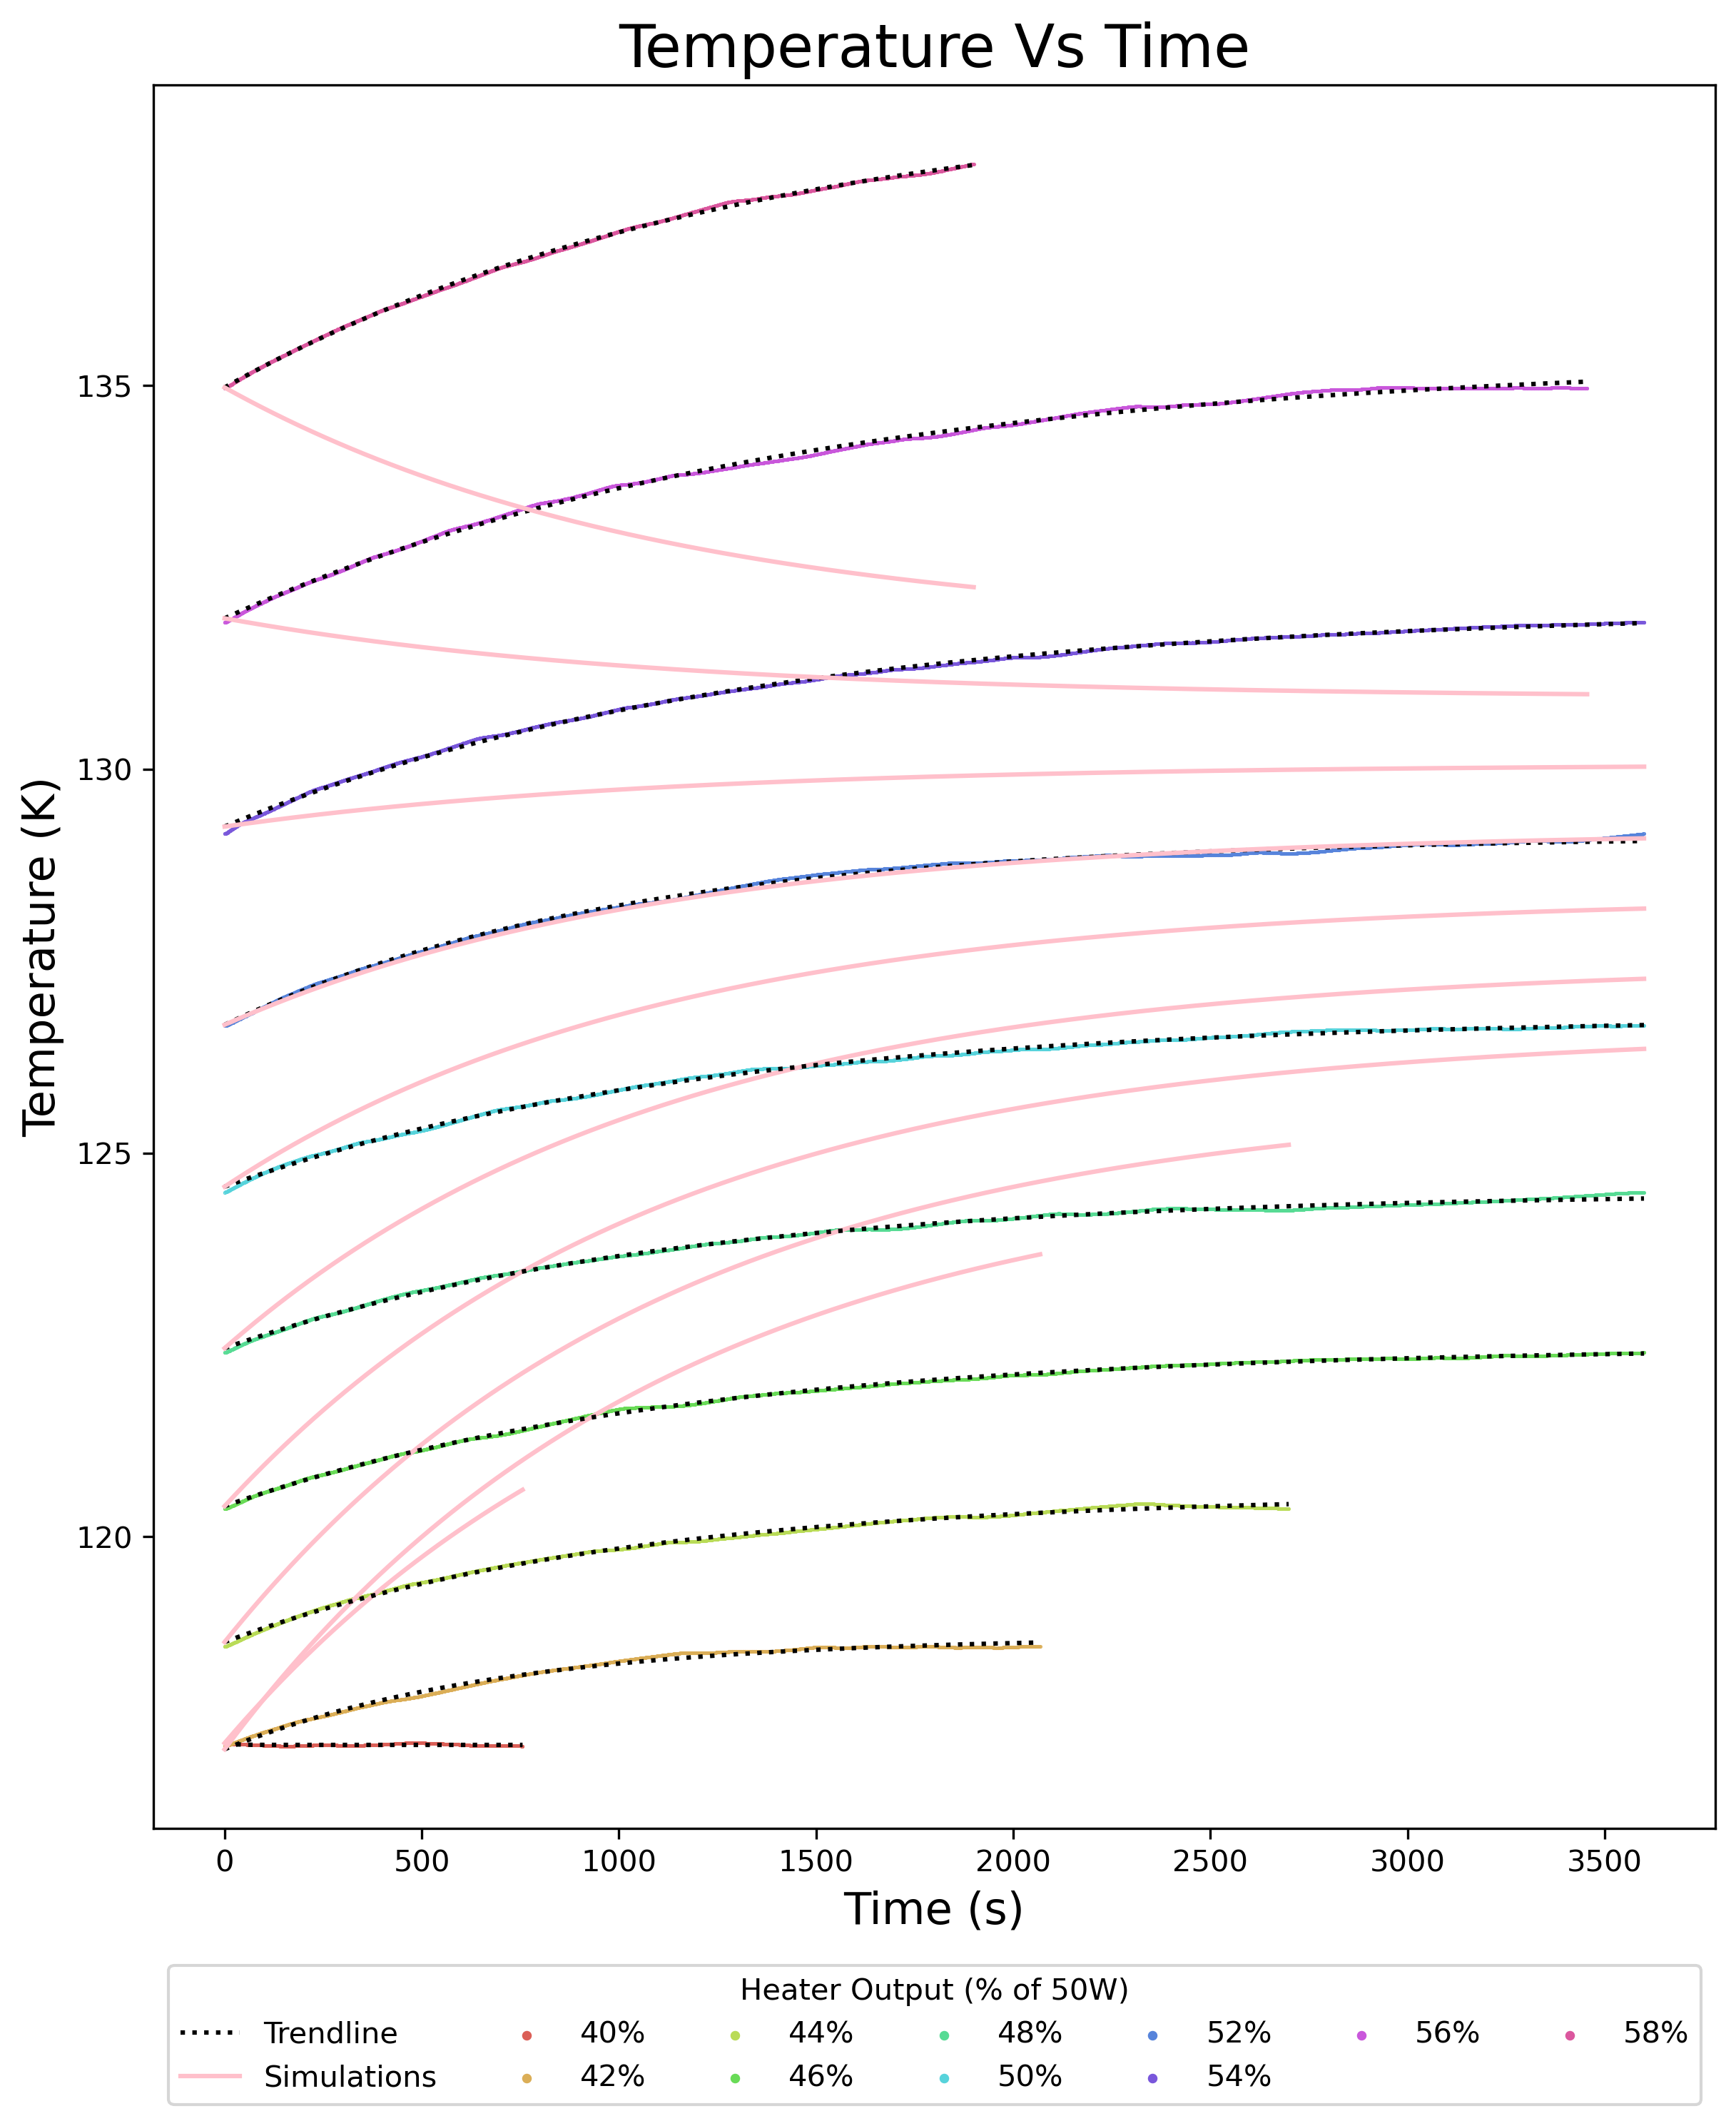

In [22]:
### COMPARES OUTPUTS TOGETHER OR ONLY ONE OUTPUT

results_S = []

### Intialiaze simultion start temp and time_S steps
dt = 0.1 #Time step in seconds
#simTime = 1800 #Time to simulate for in seconds
checkRange = 60*10 #time to measure slope/std dev of temp over
varTempLim = 0.005 #Variation allowed for steady temperature (K)
slopeLim = varTempLim/checkRange #Net slope allowed for steady temperature
#steps = int(simTime/dt) #amount of simulation steps


T_F_Vals = np.linspace(100, 102, 5)
T_F_Vals = [106.66667]
thermalMass_Vals = np.linspace(2000,4000,5)
thermalMass_Vals = [1666.66667]
scaleF_Vals = np.linspace(0.01,3,5)
scaleF_Vals = [1.5]
scaleH_Vals = np.linspace(0.01,3,5)
scaleH_Vals = [1.3]

counter = 0
bestTotalPercentDiff = float('inf')
#T_F_Vals, thermalMass_Vals, scaleF_Vals, scaleH_Vals = [101.2], [2333], [2.3], [2]

for T_F in T_F_Vals:
    for thermalMass in thermalMass_Vals:
        for scaleF in scaleF_Vals:
            for scaleH in scaleH_Vals:
                #totalPercentDiffNew = compare(T_F, thermalMass, scaleF, scaleH) #Use if you want to compare all outputs
                totalPercentDiffNew = compareOneOutput(T_F, thermalMass, scaleF, scaleH) #Use if you only want to compare one output
                counter += 1
                print(counter, ': ', totalPercentDiffNew, end='\r')
                if totalPercentDiffNew < bestTotalPercentDiff:
                    bestTotalPercentDiff = totalPercentDiffNew
                    best_params = (T_F, thermalMass, scaleF, scaleH)
                #print(round(T_F,2), round(thermalMass,2), 
                #      round(scaleF,2), round(scaleH,2))#, end='\r')
            #print(totalDiff)
T_F, thermalMass, scaleF, scaleH = best_params
print('best: ', bestTotalPercentDiff, best_params)

fig1, ax1 = plt.subplots(figsize=(8.7,10), dpi=300)
ax1 = plt.gca()
ax1.set_title('Temperature Vs Time', fontsize=20)
ax1.set_xlabel('Time (s)', fontsize=15)
ax1.set_ylabel('Temperature (K)', fontsize=15)

#best_params = (102.0, 1000.0, 1.2, 0.35)
T_F, thermalMass, scaleF, scaleH = best_params
tempFit_E = []
steadyTemp_E = []
colors = sns.color_palette('hls', len(outputList))
ax1.set_prop_cycle('color', colors)
for i in range(0, len(outputList)):
    #experiment 
    #ax1.plot(time_E[i], temp_E[i], label=str(round(outputList[i]))+'%')
    
    [KFit, tauFit, T0Fit], _ = scipy.optimize.curve_fit(fo, time_E[i], temp_E[i])
    #sigma = np.ones(len(time_E))
    #sigma[[0, -1]] = 0.01
    #[K, tau, T0], _ = scipy.optimize.curve_fit(fo, time, temp, sigma=sigma)
    tempFit_E.append(fo(time_E[i], KFit, tauFit, T0Fit)) 
    if i == 0:
        ax1.plot(time_E[i], tempFit_E[i], color='black', linestyle=':', 
                 label='Trendline')
    else:
        ax1.plot(time_E[i], tempFit_E[i], color='black', linestyle=':')
    gradient_E = []    
    for t in range(1, len(time_E[i])):
        gradient_E.append((tempFit_E[i][t]-tempFit_E[i][t-1])
                          /(time_E[i][t]-time_E[i][t-1]))
    gradients_E.append(gradient_E)
    #print(np.shape(temp_E[i]), np.shape(gradients_E[i]))
    for k in range(0, len(time_E[i])):
        if time_E[i][-1] - time_E[i][k] <= checkRange:
            steadyTemp_E.append(np.average(temp_E[i][k:]))
    
    #simulation
    #print(end='\x1b[2K')
    print(round(outputList[i],2))
    results_S.append(runSim(T0Fit, time_E[i][-1], outputList[i]/100, T_F, 
                            thermalMass, scaleF, scaleH))
    if i == 0:
        ax1.plot(results_S[i][0], results_S[i][1][:-1], color='pink',
                 label='Simulations')
    else:
        ax1.plot(results_S[i][0], results_S[i][1][:-1], color='pink')
    ax1.scatter(time_E[i], temp_E[i], label=str(round(outputList[i]))+'%', s=0.05)
#ax1.legend()
ax1.legend(title='Heater Output (% of 50W)', loc='upper left', bbox_to_anchor=(0, -0.07), ncols=7, markerscale=10)
plt.tight_layout()
plt.show()

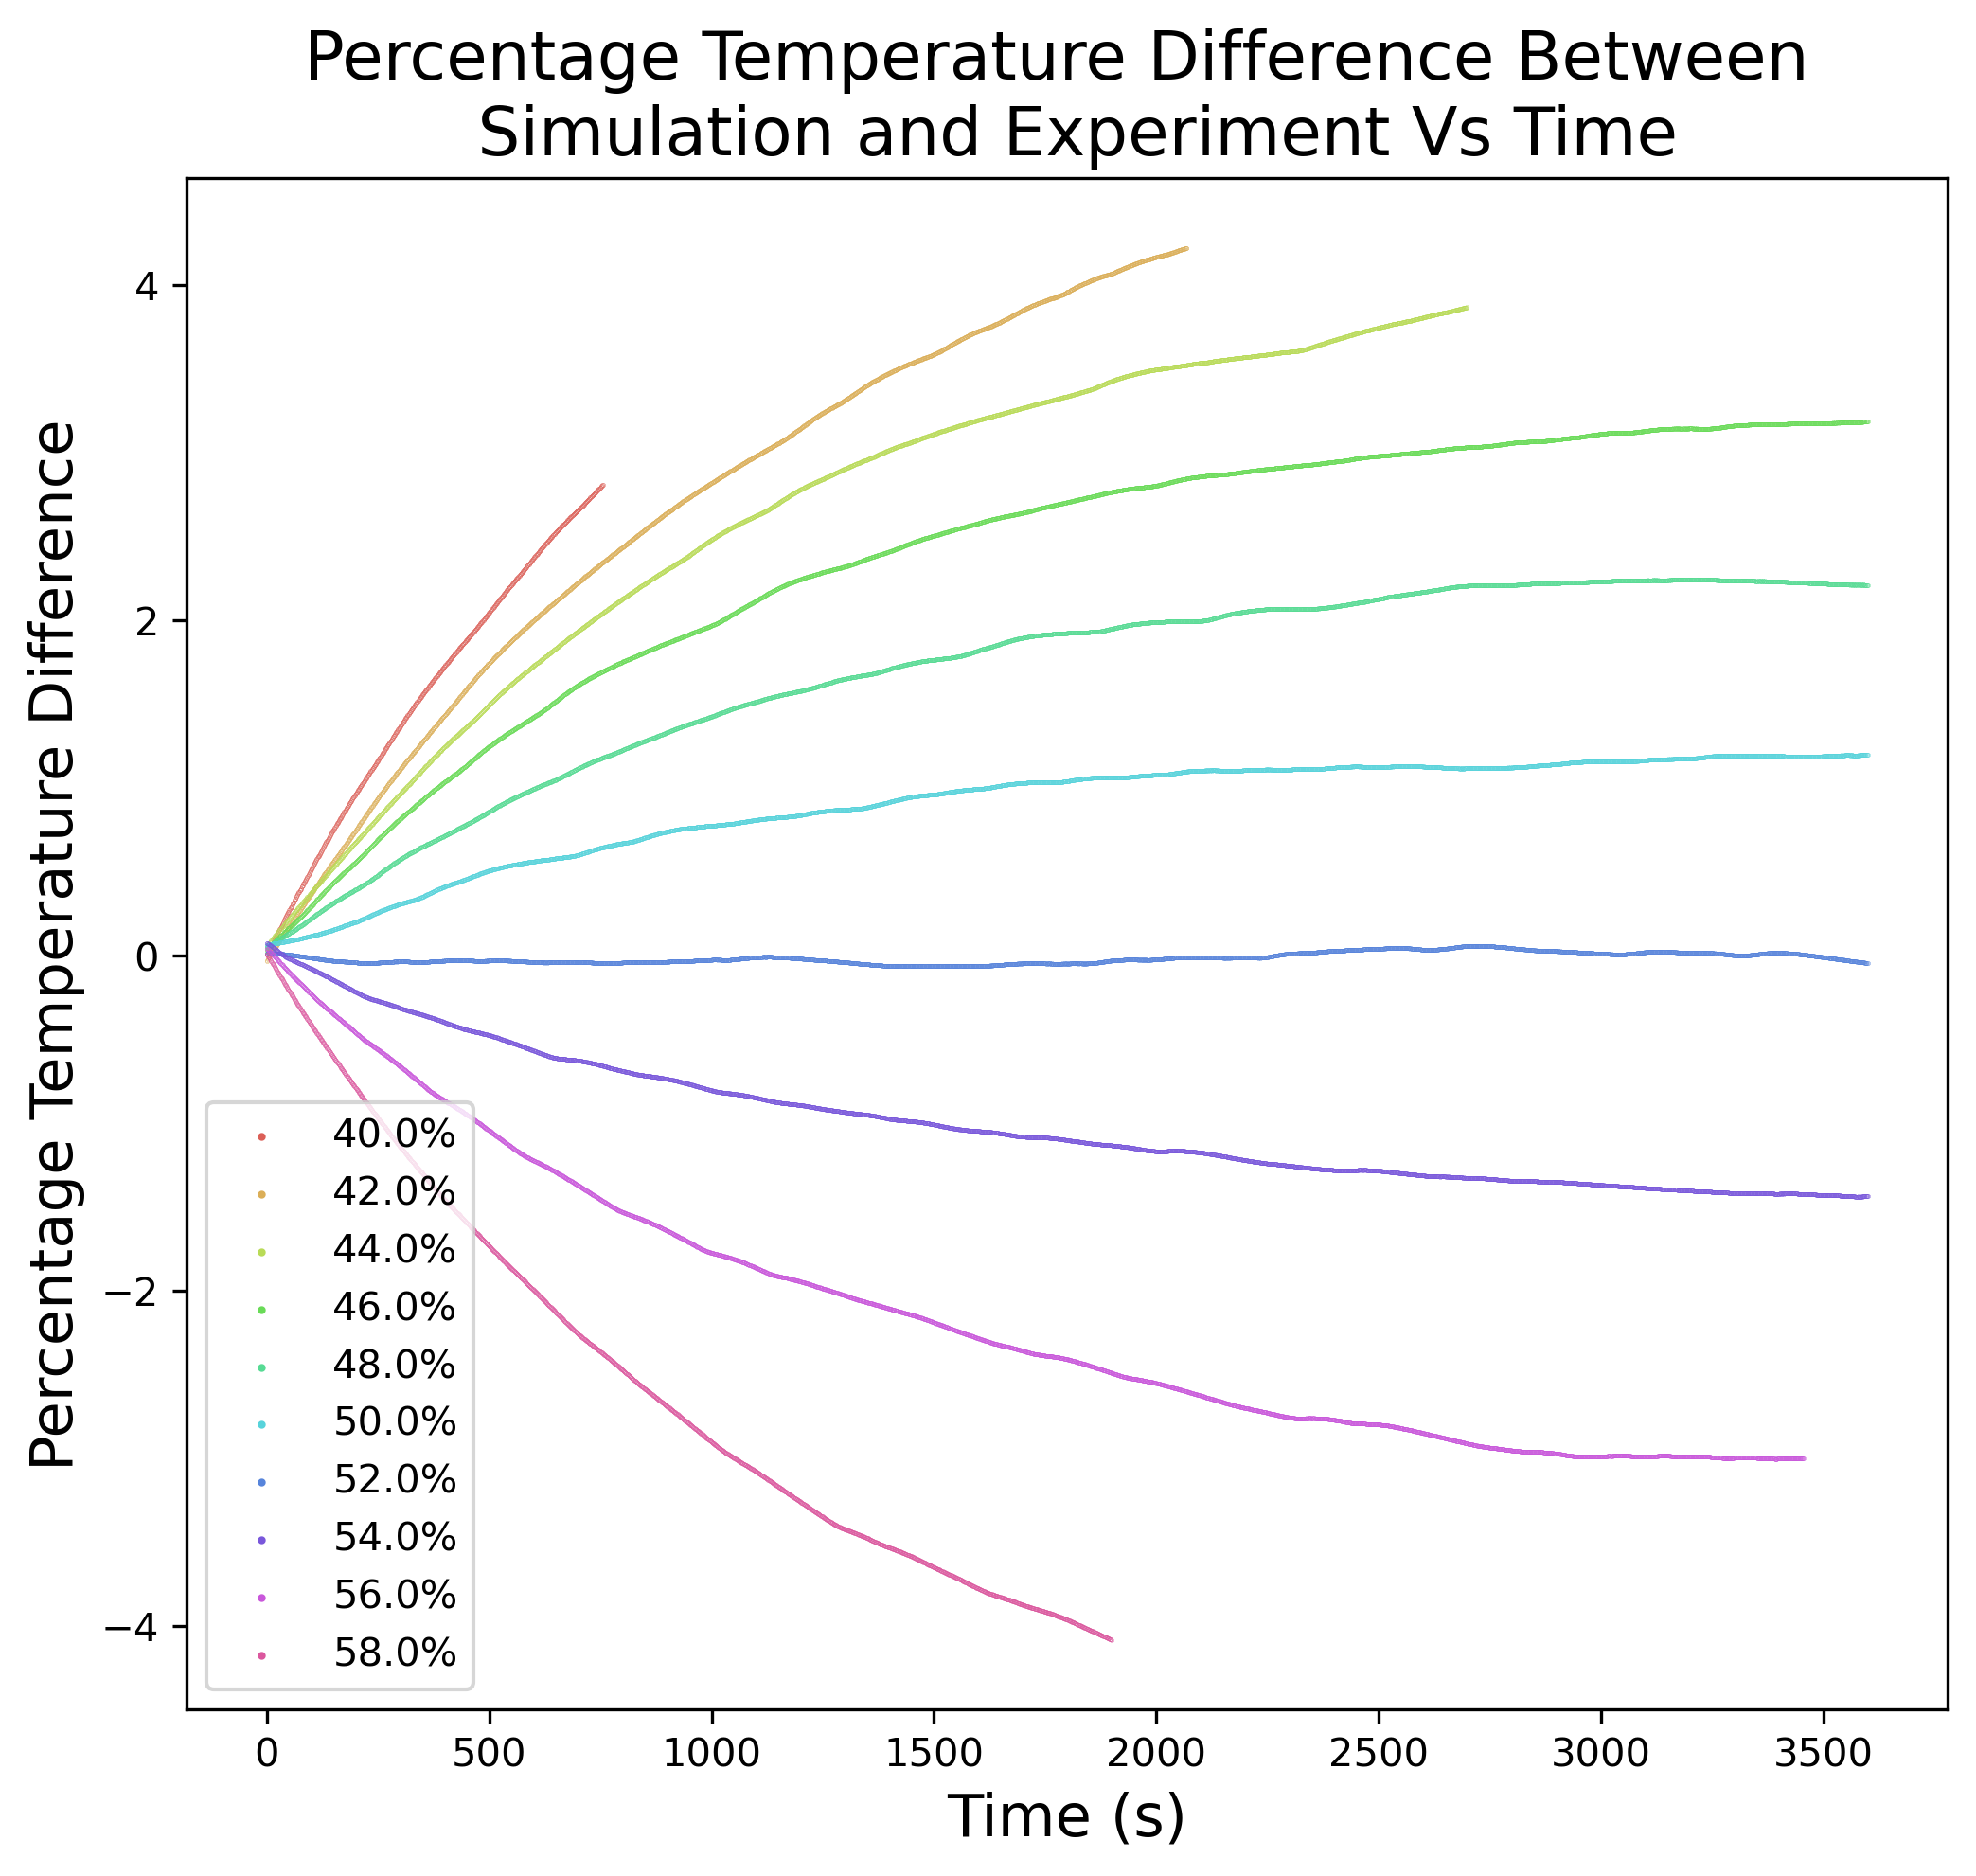

In [23]:
from scipy.interpolate import interp1d

tempInterpListsS = []
percentDiffSE = []
totPercentDiffSE = []
for i in range(0, len(outputList)):
    interpS = interp1d(results_S[i][0], results_S[i][1][:-1]) #want to interpolate the simulation
    tempInterpS = []
    for j in range(0, len(time_E[i])):#interpolate for every experimental time stamp
        tempInterpS.append(interpS(time_E[i][j]))
    tempInterpListsS.append(tempInterpS)#add reselt for list of lists for each output
    percentDiffSE.append(100*(np.array(tempInterpListsS[i]) - np.array(temp_E[i]))/(0.5*(np.array(tempInterpListsS[i]) + np.array(temp_E[i]))))
    totPercentDiffSE.append(100*(sum(np.array(tempInterpListsS[i])) - sum(np.array(temp_E[i])))/(0.5*(sum(np.array(tempInterpListsS[i])) + sum(np.array(temp_E[i])))))
fig3, ax3 = plt.subplots(figsize=(8,7),dpi=300)
colors = sns.color_palette('hls', len(outputList))
ax3.set_prop_cycle('color', colors)
for i in range(0, len(outputList)):
    ax3.scatter(time_E[i], percentDiffSE[i], label=str(round(outputList[i],2))+'%', s=0.01)
ax3.set_xlabel('Time (s)',fontsize=15)
ax3.set_ylabel('Percentage Temperature Difference', fontsize=15)
ax3.set_title('Percentage Temperature Difference Between \n Simulation and Experiment Vs Time', fontsize=17)
ax3.legend(markerscale=10) 

plt.show()

In [22]:
### FITTING RESULTS
percentDiffAll = []
percentRMSAll = 0
for i in range(0, len(outputList)):
    percentDiffAll.extend(percentDiffSE[i])
    #results_S = runSim(T0[i], time_E[i][-1], outputList[i]/100, T_F, thermalMass, scaleF, scaleH)
    #tempFitSPoints = fo(np.array(results_S[0]), T_K[i], tau[i], T0[i])
    #percentRMS = np.sqrt(np.mean(np.square(np.array((results_S[1][:-1]) - np.array(tempFitSPoints))\
                                           #/(0.5*(results_S[1][:-1] + np.array(tempFitSPoints))))))
    #percentRMSAll += percentRMS
percentRMSAll = np.sqrt(np.mean(np.square(np.array(percentDiffAll))))
#percentRMSAvg = percentRMSAll/len(outputList)
print("min error: ", min(np.array(percentDiffAll)), "max error: ", max(np.array(percentDiffAll)))
#print("average RMS error: ", percentRMSAvg * 100)
print('avg error: ', percentRMSAll)

min error:  -8.916892762476145 max error:  2.959707263558856
avg error:  2.8250405351558516


In [20]:
### COMPARES OUTPUTS SEPERATELY
results_S = []

### Intialiaze simultion start temp and time_S steps
dt = 0.1 #Time step in seconds
#simTime = 1800 #Time to simulate for in seconds
checkRange = 60*10 #time to measure slope/std dev of temp over
varTempLim = 0.005 #Variation allowed for steady temperature (K)
slopeLim = varTempLim/checkRange #Net slope allowed for steady temperature
#steps = int(simTime/dt) #amount of simulation steps

#T_F_Vals = np.linspace(100, 120, 3)
#T_F_Vals = [102]
T_F_Vals = np.linspace(100, 120, 5)
thermalMass_Vals = np.linspace(650,850,5)
scaleF_Vals = np.linspace(0.5,1,5)
scaleH_Vals = np.linspace(0.01,1,5)

best_params = compareByOutput(T_F_Vals, thermalMass_Vals, scaleF_Vals, scaleH_Vals)

fig1, ax1 = plt.subplots(figsize=(6.9,6))
ax1 = plt.gca()
ax1.set_title('Temperature Vs Time')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Temperature (K)')

print(np.shape(best_params))
best_paramsT = np.array(best_params).T
T_F = best_paramsT[0]
thermalMass = best_paramsT[1]
scaleF = best_paramsT[2]
scaleH = best_paramsT[3]
tempFit_E = []
steadyTemp_E = []
print(T_F)
for i in range(0, len(outputList)):
    #experiment 
    ax1.plot(time_E[i], temp_E[i], label=str(round(outputList[i]))+'%')
    [K, tau, T0], _ = scipy.optimize.curve_fit(fo, time_E[i], temp_E[i])
    tempFit_E.append(fo(time_E[i], K, tau, T0)) 
    if i == 1:
        ax1.plot(time_E[i], tempFit_E[i], color='black', linestyle=':', 
                 label='Trendline')
    else:
        ax1.plot(time_E[i], tempFit_E[i], color='black', linestyle=':')
    gradient_E = []    
    for t in range(1, len(time_E[i])):
        gradient_E.append((tempFit_E[i][t]-tempFit_E[i][t-1])
                          /(time_E[i][t]-time_E[i][t-1]))
    gradients_E.append(gradient_E)
    for k in range(0, len(time_E[i])):
        if time_E[i][-1] - time_E[i][k] <= checkRange:
            steadyTemp_E.append(np.average(temp_E[i][k:]))
    
    #simulation
    print(end='\x1b[2K')
    print(round(outputList[i],2))
    results_S.append(runSim(T0, time_E[i][-1], outputList[i]/100, T_F[i], 
                            thermalMass[i], scaleF[i], scaleH[i]))
    if i == 0:
        ax1.plot(results_S[i][0], results_S[i][1][:-1], color='pink',
                 label='Simulations')
    else:
        ax1.plot(results_S[i][0], results_S[i][1][:-1], color='pink')
#ax1.legend()
plt.legend(title='Heater Output (% of 50W)', loc='upper left', bbox_to_anchor=(0, -0.15), ncols=5)
plt.tight_layout()

fig2, ax2 = plt.subplots()
ax2 = plt.gca()
ax2.set_title('Gradient Vs Temperature')
ax2.set_xlabel('Temperature (K)')
ax2.set_ylabel('Gradient (K/s)')
for i in range(0, len(outputList)):
    ax2.plot(results_S[i][1][1:], results_S[i][2][1:], color='pink') 
             #label=str(round(outputList[i],2))+' sim')
    #print(gradients_E)
    ax2.plot(temp_E[i][1:], gradients_E[i], label=str(round(outputList[i],2))+' exp')
#ax2.legend()
plt.show()

Output  5.0  best params:  [100.0, 850.0, 0.875, 1.0]
Output  10.0  best params:  [100.0, 850.0, 0.75, 0.505]
Output  15.0  best params:  [100.0, 650.0, 1.0, 0.505]
Output  20.0  best params:  [100.0, 850.0, 1.0, 0.505]


KeyboardInterrupt: 

(11, 4)
[100. 100. 100. 100. 100. 100. 105. 105. 105. 110. 120.]
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0


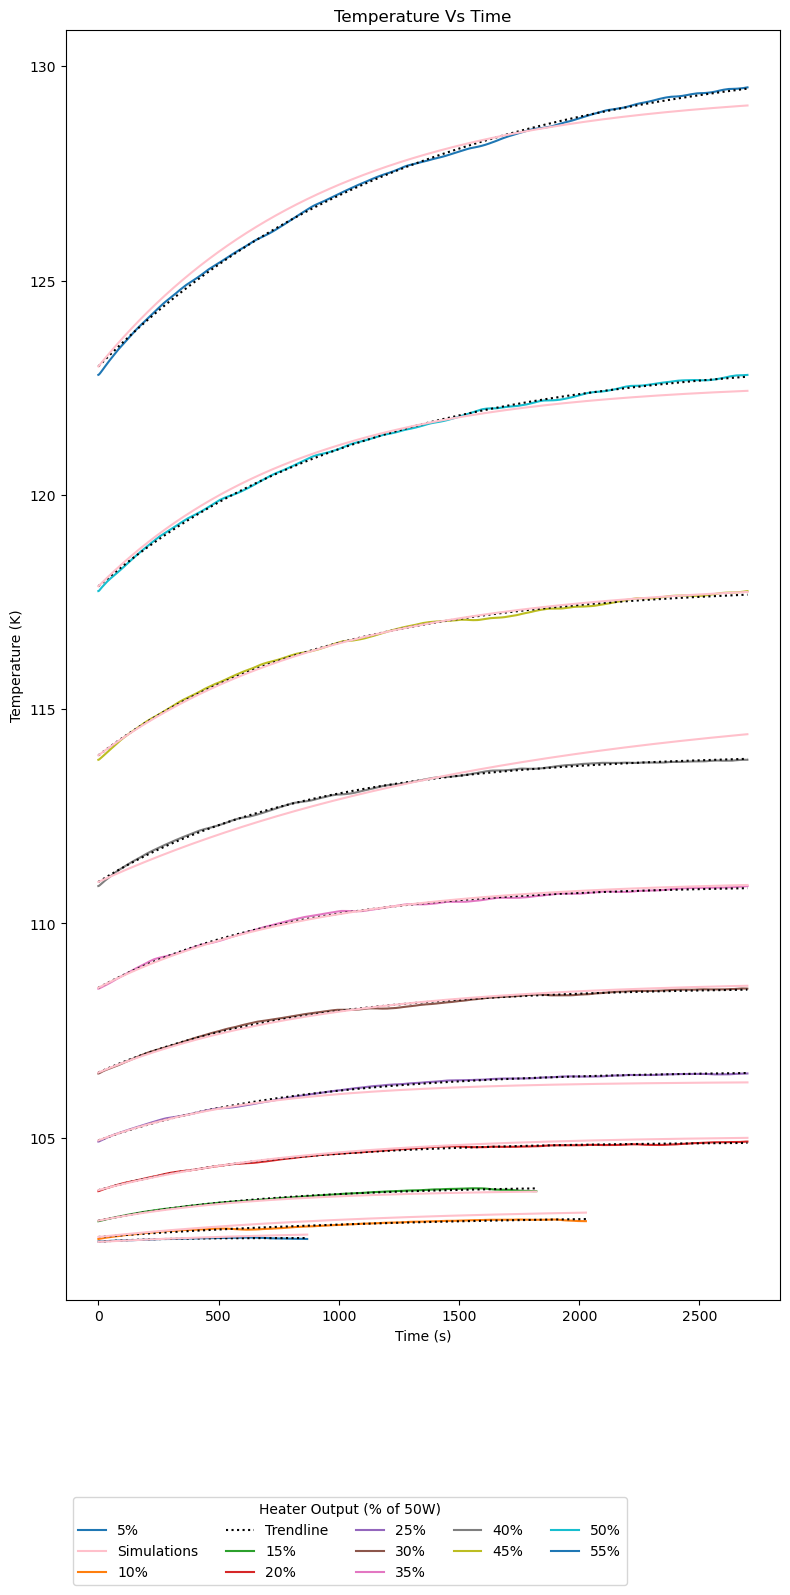

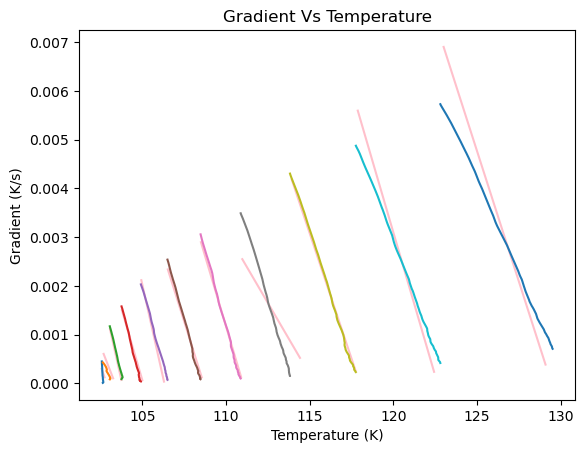

In [79]:
fig1, ax1 = plt.subplots(figsize=(8,16))
ax1 = plt.gca()
ax1.set_title('Temperature Vs Time')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Temperature (K)')

print(np.shape(best_params))
best_paramsT = np.array(best_params).T
T_F = best_paramsT[0]
thermalMass = best_paramsT[1]
scaleF = best_paramsT[2]
scaleH = best_paramsT[3]
tempFit_E = []
steadyTemp_E = []
print(T_F)
for i in range(0, len(outputList)):
    #experiment 
    ax1.plot(time_E[i], temp_E[i], label=str(round(outputList[i]))+'%')
    [K, tau, T0], _ = scipy.optimize.curve_fit(fo, time_E[i], temp_E[i])
    tempFit_E.append(fo(time_E[i], K, tau, T0)) 
    if i == 1:
        ax1.plot(time_E[i], tempFit_E[i], color='black', linestyle=':', 
                 label='Trendline')
    else:
        ax1.plot(time_E[i], tempFit_E[i], color='black', linestyle=':')
    gradient_E = []    
    for t in range(1, len(time_E[i])):
        gradient_E.append((tempFit_E[i][t]-tempFit_E[i][t-1])
                          /(time_E[i][t]-time_E[i][t-1]))
    gradients_E.append(gradient_E)
    for k in range(0, len(time_E[i])):
        if time_E[i][-1] - time_E[i][k] <= checkRange:
            steadyTemp_E.append(np.average(temp_E[i][k:]))
    
    #simulation
    print(end='\x1b[2K')
    print(round(outputList[i],2))
    results_S.append(runSim(T0, time_E[i][-1], outputList[i]/100, T_F[i], 
                            thermalMass[i], scaleF[i], scaleH[i]))
    if i == 0:
        ax1.plot(results_S[i][0], results_S[i][1][:-1], color='pink',
                 label='Simulations')
    else:
        ax1.plot(results_S[i][0], results_S[i][1][:-1], color='pink')
#ax1.legend()
plt.legend(title='Heater Output (% of 50W)', loc='upper left', bbox_to_anchor=(0, -0.15), ncols=5)
plt.tight_layout()

fig2, ax2 = plt.subplots()
ax2 = plt.gca()
ax2.set_title('Gradient Vs Temperature')
ax2.set_xlabel('Temperature (K)')
ax2.set_ylabel('Gradient (K/s)')
for i in range(0, len(outputList)):
    ax2.plot(results_S[i][1][1:], results_S[i][2][1:], color='pink') 
             #label=str(round(outputList[i],2))+' sim')
    #print(gradients_E)
    ax2.plot(temp_E[i][1:], gradients_E[i], label=str(round(outputList[i],2))+' exp')
#ax2.legend()
plt.show()

ValueError: x and y must be the same size

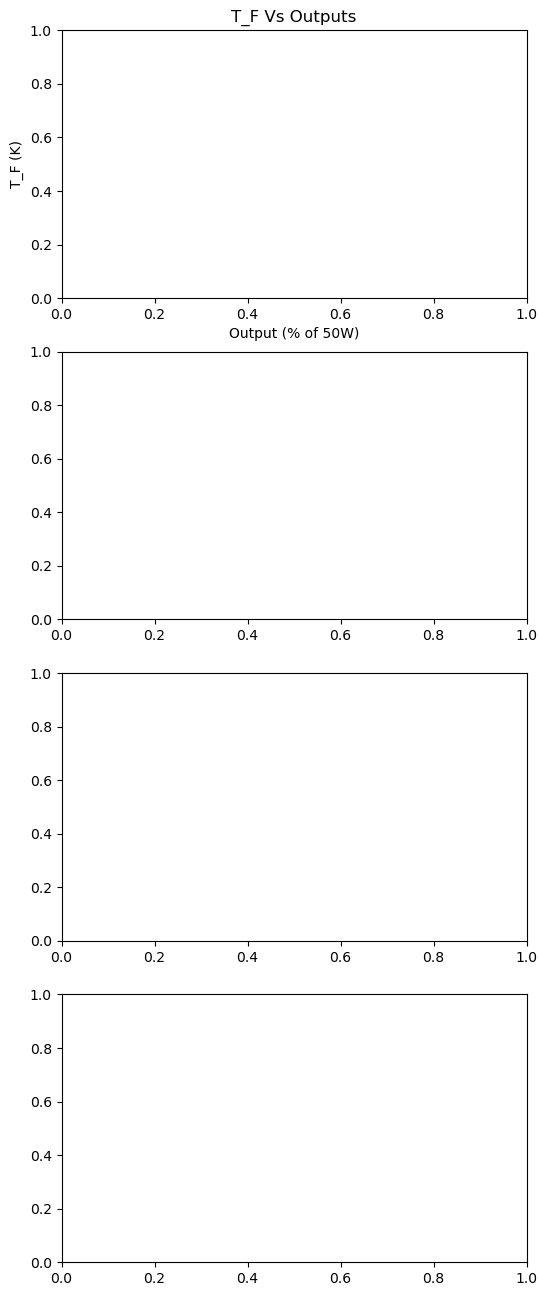

In [6]:
fig3, ax3 = plt.subplots(4, 1, figsize=(6,16))
ax3[0].set_title('T_F Vs Outputs')
ax3[0].set_xlabel('Output (% of 50W)')
ax3[0].set_ylabel('T_F (K)')
ax3[0].scatter(outputList, T_F, marker='x')
ax3[1].set_title('Thermal Mass Vs Outputs')
ax3[1].set_xlabel('Output (% of 50W)')
ax3[1].set_ylabel('Thermal Mass (J/K)')
ax3[1].scatter(outputList, thermalMass, marker='x')
ax3[2].set_title('Cooling Scale Factor Vs Outputs')
ax3[2].set_xlabel('Output (% of 50W)')
ax3[2].set_ylabel('Cooling Scale Factor')
ax3[2].scatter(outputList, scaleF, marker='x')
ax3[3].set_title('Heating Scale Factor Vs Outputs')
ax3[3].set_xlabel('Output (% of 50W)')
ax3[3].set_ylabel('Heating Scale Factor')
ax3[3].scatter(outputList, scaleH, marker='x')
plt.tight_layout()

#plot Q_H, Q_F, Q_net against temp
fig4, ax4 = plt.subplots(3, 1, figsize=(6,12))
ax4[0].set_title('Heating Power Vs Temperature')
ax4[0].set_xlabel('Temperature (K)')
ax4[0].set_ylabel('Heating Power (W)')
ax4[1].set_title('Cooling Power Vs Temperature')
ax4[1].set_xlabel('Temperature (K)')
ax4[1].set_ylabel('Cooling power (W)')
ax4[2].set_title('Net Power Vs Temperature')
ax4[2].set_xlabel('Temperature (K)')
ax4[2].set_ylabel('Net Power (W)')
for i in range(0, len(outputList)):
    ax4[0].plot(results_S[i][1][:-1], np.array(results_S[i][3])*dt, label=str(round(outputList[i],2)))
    ax4[1].plot(results_S[i][1][:-1], np.array(results_S[i][4])*dt*-1, label=str(round(outputList[i],2)))
    ax4[2].plot(results_S[i][1][:-1], np.array(results_S[i][5])*dt, label=str(round(outputList[i],2)))
plt.tight_layout()
plt.show()

(4, 61)
[1.02e+02 6.50e+02 5.00e-01 1.00e-02]
5.0
10.0
15.0
20.0
25.0


IndexError: index 4 is out of bounds for axis 0 with size 4

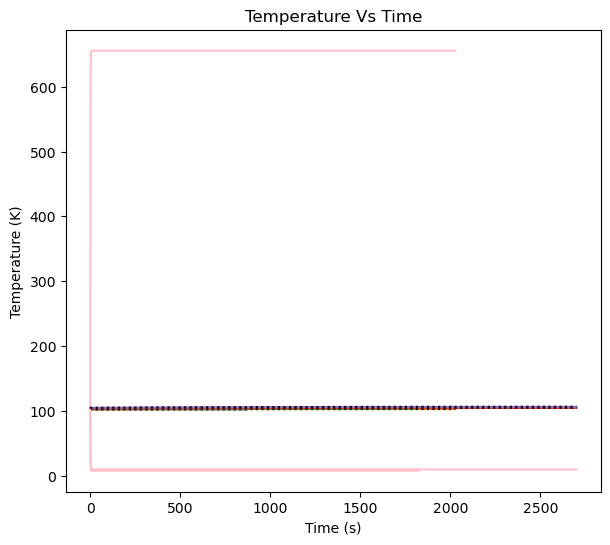

In [48]:
fig1, ax1 = plt.subplots(figsize=(6.9,6))
ax1 = plt.gca()
ax1.set_title('Temperature Vs Time')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Temperature (K)')

print(np.shape(best_params))
best_paramsT = np.array(best_params).T
T_F = best_paramsT[0]
thermalMass = best_paramsT[1]
scaleF = best_paramsT[2]
scaleH = best_paramsT[3]
tempFit_E = []
steadyTemp_E = []
print(T_F)

for i in range(0, len(outputList)):
    #experiment 
    ax1.plot(time_E[i], temp_E[i], label=str(round(outputList[i]))+'%')
    [K, tau, T0], _ = scipy.optimize.curve_fit(fo, time_E[i], temp_E[i])
    tempFit_E.append(fo(time_E[i], K, tau, T0)) 
    if i == 1:
        ax1.plot(time_E[i], tempFit_E[i], color='black', linestyle=':', 
                 label='Trendline')
    else:
        ax1.plot(time_E[i], tempFit_E[i], color='black', linestyle=':')
    gradient_E = []    
    for t in range(1, len(time_E[i])):
        gradient_E.append((tempFit_E[i][t]-tempFit_E[i][t-1])
                          /(time_E[i][t]-time_E[i][t-1]))
    gradients_E.append(gradient_E)
    for k in range(0, len(time_E[i])):
        if time_E[i][-1] - time_E[i][k] <= checkRange:
            steadyTemp_E.append(np.average(temp_E[i][k:]))
    
    #simulation
    print(end='\x1b[2K')
    print(round(outputList[i],2))
    results_S.append(runSim(T0, time_E[i][-1], outputList[i]/100, T_F[i], 
                            thermalMass[i], scaleF[i], scaleH[i]))
    if i == 0:
        ax1.plot(results_S[i][0], results_S[i][1][:-1], color='pink',
                 label='Simulations')
    else:
        ax1.plot(results_S[i][0], results_S[i][1][:-1], color='pink')
#ax1.legend()
plt.legend(title='Heater Output (% of 50W)', loc='upper left', bbox_to_anchor=(0, -0.15), ncols=5)
plt.tight_layout()

fig2, ax2 = plt.subplots()
ax2 = plt.gca()
ax2.set_title('Gradient Vs Temperature')
ax2.set_xlabel('Temperature (K)')
ax2.set_ylabel('Gradient (K/s)')
for i in range(0, len(outputList)):
    ax2.plot(results_S[i][1][1:], results_S[i][2][1:], color='pink') 
             #label=str(round(outputList[i],2))+' sim')
    #print(gradients_E)
    ax2.plot(temp_E[i][1:], gradients_E[i], label=str(round(outputList[i],2))+' exp')
#ax2.legend()
plt.show()

In [7]:
print(T_F, thermalMass, scaleF, scaleH)

102 1000.0 0.8 0.5


In [ ]:
fig4, ax4 = plt.subplots()
ax4 = plt.gca()
ax4.plot(outputList, steadyTemp_S, label='sim')
ax4.plot(outputList, steadyTemp_E, label='exp')
ax4.set_xlabel('Output (% of 50W)')
ax4.set_ylabel('Steady Temperature (K)')
plt.title('Steady Temperature Vs Power Output')
ax4.legend()

fig5, ax5 = plt.subplots()
ax5 = plt.gca()

ax5.set_xlabel('Power Output (% of 50W)')
ax5.set_ylabel('Tau (s))')
ax5.legend()
plt.title('Tau Vs Power Output')

plt.show()

In [ ]:
#fig3, ax3 = plt.subplots()
#ax3 = plt.gca()
#ax3.set_title('Gradient of Gradient Vs Temperature')
#ax3.set_xlabel('Temperature (K)')
#ax3.set_ylabel('K^2/s')
#for j in range(0, len(outputList)):
#    temp_S = results_S[j][1][1:]
#    gradient_S = results_S[j][2][1:]
#    gradGradient_S = []; gradGradient_E = []
#    for k in range(1, len(gradient_S)):
#        gradGradient_S.append((gradient_S[k]-gradient_S[k-1])
#                              /(temp_S[k]-temp_S[k-1]))
#    ax3.plot(temp_S[1:], gradGradient_S,
#             label=str(round(outputList[j],2))+' sim')
#    temp_E = resultArrs_E[j][1]
#    temp_E = list(map(float, temp_E))
#    for k in range(1, len(gradients_E[j])):
#        gradGradient_E.append((gradients_E[j][k]-gradients_E[j][k-1])
#                              /(temp_E[k]-temp_E[k-1]))
#    ax3.plot(temp_E[2:], gradGradient_E,
#             label=str(round(outputList[j],2))+' exp')
#ax3.legend()

In [ ]:
logOutputList = np.log(outputList)
T_KLogFit = np.poly1d(np.polyfit(logOutputList, T_K, 1))
tauLogFit = np.poly1d(np.polyfit(logOutputList, tau, 2))

fig2, ax2 = plt.subplots(2, 1, figsize=(6, 8))
ax2[0].set_title('Gain Temperature Vs Outputs')
ax2[0].set_xlabel('Output (%)')
ax2[0].set_ylabel('Gain Temperature (K)')
ax2[0].scatter(logOutputList, T_K, marker='x', 
               label='Experiement')
ax2[0].plot(logOutputList, T_KLogFit(logOutputList), linestyle=':', 
            label='Trendline', color='black')
ax2[0].legend()
ax2[1].set_title('Tau Vs Outputs')
ax2[1].set_xlabel('Output (%)')
ax2[1].set_ylabel('Tau (s)')
ax2[1].scatter(logOutputList, tau, marker='x', 
               label='Experiement')
ax2[1].plot(logOutputList, tauLogFit(logOutputList), linestyle=':', 
            label='Trendline', color='black')
ax2[1].legend()
plt.tight_layout()